In [1]:
import random, time
from tqdm.notebook import tqdm_notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, SubsetRandomSampler, DataLoader, random_split
from torch.optim.lr_scheduler import ExponentialLR, CosineAnnealingLR

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as mse

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(device))
rmse = lambda y, yHat: np.sqrt(mse(yHat, y))

NVIDIA GeForce RTX 3090 Ti


In [2]:

rawFilePath = "./data/data.csv"
sampleFilePath = "./data/sample_10k.csv"

colRaw = ["latitude","longitude","value","radiation","aqi","co","dew",
        "so2","no2","o3","city","radiation2","value2","height","surface",]
col = ["latitude", "longitude", "value", "aqi","so2", "no2", "o3", "value2"]
colType = {"latitude":np.float64, "longitude":np.float64, "value":np.float64, 
        "aqi":np.float64,"so2":np.float64, "no2":np.float64, "o3":np.float64, 
        "value2":np.float64}

rawCnt = 12919142 # obtained from file
sampleCnt = 10000

''' Initial Sampling, run once '''
if False:
    skipIndex = lambda n, k: sorted(random.sample(range(1,n+1),n-k)) # random select skipping rows
    df = pd.read_csv(rawFilePath, skiprows=skipIndex(rawCnt, sampleCnt), 
        encoding='utf-8', header=None, names=colRaw, dtype=colType, na_values=['-'])
    dfCleaned = df[col].dropna() # remove 
    dfCleaned.to_csv(sampleFilePath, encoding='utf-8',index=False)

In [3]:
class AirQualityDataset(Dataset):
    def __init__(self, csvFile):
        self.df = pd.read_csv(csvFile, encoding='utf-8')
        self.df = AirQualityDataset.normalize(self.df)
        self.target = "aqi"

        self.X = self.df.drop(self.target, axis=1)
        self.y = self.df[self.target]

    @staticmethod
    def normalize(df):
        means,stds = {},{}
        for n in df.columns:
            means[n],stds[n] = df[n].mean(),df[n].std()
            df[n] = (df[n]-means[n]) / (1e-7 + stds[n])
        return df


    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if isinstance(idx, torch.Tensor):
            idx = idx.tolist()
        
        return [self.X.iloc[idx].values, self.y[idx]]

In [4]:
class Net(nn.Module):
    def __init__(self, D_in, H, D_out=1):
        super().__init__()
        self.fc1 = nn.Linear(D_in, H)
        self.fc2 = nn.Linear(H, D_out)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x.squeeze()

    def resetWeights(self):
        for layer in self.children():
            if hasattr(layer, 'reset_parameters'):
                # print(f'Reset trainable parameters of layer = {layer}')
                layer.reset_parameters()



In [5]:
# help functions

from collections.abc import Iterable
from typing import List


def myLayer(n_in:int, n_out:int, bn:bool=True, p:float=0., activLayer=None):
    "Sequence of batchnorm (if `bn`), dropout (with `p`) and linear (`n_in`,`n_out`) layers followed by `activLayer`."
    layers = []
    if bn: 
        layers.append(nn.BatchNorm1d(n_in))
    if p != 0: 
        layers.append(nn.Dropout(p))
    layers.append(nn.Linear(n_in, n_out))
    if activLayer is not None: 
        layers.append(activLayer)
    return layers
       

class Net2(nn.Module):
    "Basic model for tabular data."
    def __init__(self, catDims:List[int], cntNum:int, out_sz:int, layers:List[int], 
                dropPcts:List[float], embDropPct:float=0., y_range=List[float], 
                use_bn:bool=True, bn_final:bool=False):
        super().__init__()
        self.catDims = catDims
        self.cntNum = cntNum
        self.y_range = y_range

        # check dropout pct list is good
        if (type(dropPcts) is not list) or (len(dropPcts) != len(layers)):
            raise ValueError(f"Dropout size incorrect: is {len(dropPcts)} should be {len(layers)}")
        
        # create categorical embeddings
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in self.catDims]) # embedding layers for categoricals as list
        self.cntEmb = sum(e.embedding_dim for e in self.embeds) # cntEmb = 0 if no categorical data
        self.embDropPct = nn.Dropout(embDropPct)
        
        # numerical batchnorm
        self.bcntNum = nn.BatchNorm1d(self.cntNum)
        
        # Count total
        
        layerSizes = [self.cntEmb + self.cntNum] + layers + [out_sz] 
        activLayers = [nn.ReLU(inplace=True) for _ in range(len(layerSizes)-2)] + [None]

        # Chaining Layers
        layers = []
        degIns, degOuts = layerSizes[:-1], layerSizes[1:]
        dropPcts = [0.] + dropPcts # no dropout for first layer
        for i,(degIn, degOut, dropPct, activ) in enumerate(zip(degIns, degOuts, dropPcts, activLayers)):
            layers += myLayer(degIn, degOut, bn=use_bn and i!=0, p=dropPct, activLayer=activ)
        if bn_final: 
            layers.append(nn.BatchNorm1d(layerSizes[-1]))

        self.layers = nn.Sequential(*layers)


    def forward(self, xCont, xCat=None):
        if self.catDims != [] and xCat != None: # have categorical columns
            x = [e(xCat[:,i]) for i,e in enumerate(self.embeds)] #take the embedding list and grab an embedding and pass in our single row of data.        
            x = torch.cat(x, 1) # concatenate it on dim 1 ## remeber that the len is the batch size
            x = self.embDropPct(x) # pass it through a dropout layer
        if self.cntNum != 0:
            xCont = self.bcntNum(xCont) # batchnorm1d
            x = torch.cat([x, xCont], 1) if self.catDims != [] else xCont # combine the categircal and continous variables on dim 1
        x = self.layers(x)
        if self.y_range is not None:
            x = (self.y_range[1]-self.y_range[0]) * torch.sigmoid(x) + self.y_range[0] # deal with y_range
        return x.squeeze()
    
    def resetWeights(self):
        for layer in self.layers:
            if hasattr(layer, 'reset_parameters'):
                # print(f'Reset trainable parameters of layer = {layer}')
                layer.reset_parameters()
    

In [6]:
def fit(model, trainDl, valDl, lossFn, optimizer, scheduler, epochs):
    lr = []
    lossTrain, accTrain = [], []
    lossVal, accVal = [], []
    
    pbarIter = tqdm_notebook(iter(range(epochs)), leave=False, total=epochs)
    for epoch in pbarIter:
        pbarIter.set_description(f"Epoch {epoch}")
        yTrainAll, yHatTrainAll = [], []
        yValAll, yHatValAll = [], []
        lossTrainSum = 0.0
        lossValSum = 0.0


        ''' Train '''
        for X, y in trainDl:
            # Init
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            # Predict
            yHat = model(X.float())
            loss = lossFn(yHat, y.float())
            # Stats
            lr.append(optimizer.param_groups[0]['lr'])
            yTrainAll += list(y.cpu().data.numpy())
            yHatTrainAll += list(yHat.cpu().data.numpy())
            lossTrainSum += loss.item()
            # backprop
            loss.backward()
            optimizer.step()
            if(scheduler != None): scheduler.step()
        # Epoch stats
        lossTrain.append(lossTrainSum / len(trainDl))
        accTrain.append(rmse(yTrainAll, yHatTrainAll))
        pbarIter.set_postfix(loss=lossTrain[-1])


        ''' Validation '''
        torch.set_grad_enabled(False)
        for X, y in valDl:
            # Init
            X = X.to(device)
            y = y.to(device)
            # Predict
            yHat = model(X.float())
            loss = lossFn(yHat, y.float())
            # stats
            yValAll += list(y.cpu().data.numpy())
            yHatValAll += list(yHat.cpu().data.numpy())
            lossValSum += loss.item()
        torch.set_grad_enabled(True)
        # Epoch stats
        lossVal.append(lossValSum / len(valDl))
        accVal.append(rmse(yValAll, yHatValAll))
        
    return lossTrain, accTrain, lossVal, accVal, lr

In [7]:
# Testing
def test(model, testDl, lossFn): # model, trainDl, valDl, lossFn, optimizer, epochs
    yTestAll, yHatTestAll = [], []
    lossTestSum = 0.0
    for i, (X, y) in enumerate(testDl):
        # Init
        X = X.to(device)
        y = y.to(device)
        # Predict
        yHat = model(X.float())
        loss = lossFn(yHat, y.float())
        # stats
        yTestAll += list(y.cpu().data.numpy())
        yHatTestAll += list(yHat.cpu().data.numpy())
        lossTestSum += loss.item()
    # stats
    loss = lossTestSum / (i + 1)
    acc = rmse(yTestAll, yHatTestAll)
    return loss, acc

In [8]:
class ListAverager:
    def __init__(self):
        self.ls = []
        self.cnt = 0
    
    def append(self, l):
        self.ls.append(l)
        self.cnt += 1
    
    def avg(self):
        lsNp = np.array(self.ls)
        return np.mean(lsNp, axis=0)


def plotSingle(l, label):
    plt.plot(np.arange(len(l)), l, label=label)
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.legend()
    plt.show()
def plotList(ll, labels):
    colors = ["b", "r", "b", "r"]
    linestyles = ["dashdot", "dashdot", "solid", "solid"]
    for ls, label, color, linestyle in zip(ll, labels, colors, linestyles):
        plt.plot(np.arange(len(ls)), ls, color=color, linestyle = linestyle, label=label)
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.legend()
    plt.show()


--- Fold 0 ---


  0%|          | 0/100 [00:00<?, ?it/s]

--- Fold 1 ---


  0%|          | 0/100 [00:00<?, ?it/s]

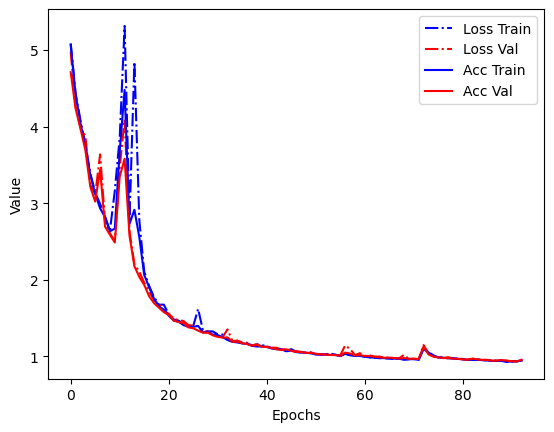

Test loss: 0.9644524515891562, acc: 0.9822931550404637


In [10]:
# Setup Model
kFolds = 2
numEpochs = 100
batchSize = 32
learningRate = 1e-3
weightDecay = 1e-4
lossFunction = nn.MSELoss()

# Load Data
dataset = AirQualityDataset(sampleFilePath)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
trainset, testset = random_split(dataset, [train_size, test_size])

# Start Training
kfold = KFold(n_splits=kFolds, shuffle=True)
lossTrains, accTrains, lossVals, accVals, lrs = [ListAverager() for _ in range(5)]
for fold, (trainIdx, valIdx) in enumerate(kfold.split(trainset)):
    print(f"--- Fold {fold} ---")
    trainSubsampler = SubsetRandomSampler(trainIdx)
    valSubsampler = SubsetRandomSampler(valIdx)
    trainLoader = DataLoader(dataset, batch_size=batchSize, sampler=trainSubsampler)
    valLoader = DataLoader(dataset, batch_size=batchSize, sampler=valSubsampler)

    # degIn = len(col)-1
    # degFeat = 10
    # network = Net(degIn, degFeat).to(device)
    network = Net2(catDims=[], cntNum=len(col)-1, out_sz=1, layers=[1000,500,250],
            dropPcts=[0.001,0.01,0.01], y_range=[0.0, 500.0]).to(device)
    network.resetWeights()
    optimizer = optim.Adam(network.parameters(), lr=learningRate, weight_decay=weightDecay)
    # lr_cosine = CosineAnnealingLR(optimizer,T_max = 350)
    # lr_cosine = ExponentialLR(optimizer, gamma=0.1)
    lr_cosine = None
    
    lossTrain, accTrain, lossVal, accVal, lr = fit(network, 
                trainLoader, valLoader, lossFunction, optimizer, lr_cosine, numEpochs)
    lossTrains.append(lossTrain)
    accTrains.append(accTrain)
    lossVals.append(lossVal)
    accVals.append(accVal)
    lrs.append(lr)
lossTrain = np.sqrt(lossTrains.avg()) # use rmse
accTrain = accTrains.avg()
lossVal = np.sqrt(lossVals.avg()) # use rmse
accVal = accVals.avg()
lr = lrs.avg()
plotList([lossTrain[7:], lossVal[7:], accTrain[7:], accVal[7:]], ["Loss Train", "Loss Val", "Acc Train", "Acc Val"])
testLoader = torch.utils.data.DataLoader(testset, batch_size=batchSize, shuffle=True)
loss, acc = test(network, testLoader, lossFunction)
print(f"Test loss: {loss}, acc: {acc}")